In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, Concatenate, add, BatchNormalization, Activation
import os
import glob
import tifffile as tiff
# import numpy as np
# import os
# import matplotlib.pyplot as plt
# from sklearn.metrics import precision_score, recall_score, f1_score
from PIL import Image
import rasterio
from sklearn.model_selection import train_test_split;
import re
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
import matplotlib.pyplot as plt
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

c:\Users\ADMIN\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
c:\Users\ADMIN\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
def conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)

    return conv2

In [5]:
def residual_conv_block(x, filters, batchnorm=True):
    conv1 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        conv1 = BatchNormalization(axis=3)(conv1)
    conv1 = Activation('relu')(conv1)    
    conv2 = Conv2D(filters, (3, 3), kernel_initializer='he_normal', padding='same')(conv1)
    if batchnorm is True:
        conv2 = BatchNormalization(axis=3)(conv2)
    conv2 = Activation("relu")(conv2)
        
    #skip connection    
    shortcut = Conv2D(filters, kernel_size=(1, 1), kernel_initializer='he_normal', padding='same')(x)
    if batchnorm is True:
        shortcut = BatchNormalization(axis=3)(shortcut)
    shortcut = Activation("relu")(shortcut)
    respath = add([shortcut, conv2])       
    return respath

In [6]:
def dense_block(inputs, num_filters):
    conv1 = conv_block(inputs, num_filters)
    concat = Concatenate()([inputs, conv1])
    return concat

In [7]:
def residual_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = residual_conv_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = residual_conv_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = residual_conv_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = residual_conv_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [8]:
def dense_unet(input_shape):
    inputs = Input(input_shape)
    
    # Encoder
    conv1 = dense_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = dense_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = dense_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = dense_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottleneck
    conv5 = Conv2D(1024, 3, activation='relu', kernel_initializer='he_normal', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), kernel_initializer='he_normal', padding='same')(conv5)
    drop5 = Dropout(0.5)(conv5)
    
    # Decoder
    up6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(drop5)
    up6 = Concatenate()([up6, conv4])
    conv6 = residual_conv_block(up6, 512)
    up7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6)
    up7 = Concatenate()([up7, conv3])
    conv7 = residual_conv_block(up7, 256)
    up8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7)
    up8 = Concatenate()([up8, conv2])
    conv8 = residual_conv_block(up8, 128)
    up9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8)
    up9 = Concatenate()([up9, conv1])
    conv9 = residual_conv_block(up9, 64)
    
    # Output
    outputs = Conv2D(1, 1, activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [9]:
def load_data(input_dir, mask_dir):
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories and sort them numerically
    input_files = sorted(glob.glob(os.path.join(input_dir, '*.tif')), key=numerical_sort)
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')), key=numerical_sort)

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for input_file, mask_file in zip(input_files, mask_files):
        # Read input file
        with rasterio.open(input_file) as src:
            img = src.read(1)  # Read the first band assuming it's a single-band image
            # print(f"Reading image from {input_file}")
            images.append(img)

        # Read mask file
        with rasterio.open(mask_file) as src:
            msk = src.read(1)  # Read the first band assuming it's a single-band image
            # print(msk)
            masks.append(msk)

    return np.array(images), np.array(masks)


In [22]:
def load_data_new(input_dir, mask_dir):
    
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories
    input_files = glob.glob(os.path.join(input_dir, '*.tif'))
    mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for mask_file in mask_files:
        # Extract the number i from the mask filename
        match = re.search(r'NDWI_Mask_(\d+)_resized.tif', os.path.basename(mask_file))
        print(match)
        if match:
            i = match.group(1)
            input_file = os.path.join(input_dir, f'{i}.tif')
            # print("Input File : ",input_file)
            # Check if the corresponding input file exists
            if os.path.exists(input_file):
                # Read input file
                with rasterio.open(input_file) as src:
                    img = src.read(1)  # Read the first band assuming it's a single-band image
                    images.append(img)

                # Read mask file
                with rasterio.open(mask_file) as src:
                    msk = src.read(1)  # Read the first band assuming it's a single-band image
                    masks.append(msk)
            else:
                print(f"Corresponding input file {input_file} for mask {mask_file} not found.")
        # break
    if not images or not masks:
        print("No matching pairs of images and masks found.")
        return None, None

    return np.array(images), np.array(masks)

In [11]:
# def load_data_test_new(input_dir, mask_dir):
    
#     def numerical_sort(value):
#         numbers = re.findall(r'\d+', os.path.basename(value))
#         return int(numbers[-1]) if numbers else -1

#     # Ensure the directories exist
#     if not os.path.exists(input_dir):
#         print(f"Input directory {input_dir} does not exist.")
#         return None, None
    
#     if not os.path.exists(mask_dir):
#         print(f"Mask directory {mask_dir} does not exist.")
#         return None, None

#     # Search for .tif files in the directories
#     input_files = glob.glob(os.path.join(input_dir, '*.tif'))
#     mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

#     print("Found input files:", input_files)
#     print("Found mask files:", mask_files)

#     if not input_files:
#         print(f"No input files found in {input_dir}.")
#         return None, None

#     if not mask_files:
#         print(f"No mask files found in {mask_dir}.")
#         return None, None

#     images = []
#     masks = []

#     for mask_file in mask_files:
#         # Extract the number i from the mask filename
#         match = re.search(r'NDWI_Mask_(\d+)_resized_corrupt.tif', os.path.basename(mask_file))
#         if match:
#             i = match.group(1)
#             input_file = os.path.join(input_dir, f'{i}.tif')
            
#             # Check if the corresponding input file exists
#             if os.path.exists(input_file):
#                 # Read input file
#                 with rasterio.open(input_file) as src:
#                     img = src.read(1)  # Read the first band assuming it's a single-band image
#                     images.append(img)

#                 # Read mask file
#                 with rasterio.open(mask_file) as src:
#                     msk = src.read(1)  # Read the first band assuming it's a single-band image
#                     masks.append(msk)
#             else:
#                 print(f"Corresponding input file {input_file} for mask {mask_file} not found.")

#     if not images or not masks:
#         print("No matching pairs of images and masks found.")
#         return None, None

#     return np.array(images), np.array(masks)

In [12]:
def load_data_test(input_dir, mask_dir):
    
    def numerical_sort(value):
        numbers = re.findall(r'\d+', os.path.basename(value))
        return int(numbers[-1]) if numbers else -1

    # Ensure the directories exist
    if not os.path.exists(input_dir):
        print(f"Input directory {input_dir} does not exist.")
        return None, None
    
    if not os.path.exists(mask_dir):
        print(f"Mask directory {mask_dir} does not exist.")
        return None, None

    # Search for .tif files in the directories
    input_files = glob.glob(os.path.join(input_dir, '*.tif'))
    mask_files = glob.glob(os.path.join(mask_dir, '*.tif'))

    print("Found input files:", input_files)
    print("Found mask files:", mask_files)

    if not input_files:
        print(f"No input files found in {input_dir}.")
        return None, None

    if not mask_files:
        print(f"No mask files found in {mask_dir}.")
        return None, None

    images = []
    masks = []

    for mask_file in mask_files:
        # Extract the number i from the mask filename
        match = re.search(r'NDWI_Mask_(\d+)_resized.tif', os.path.basename(mask_file))
        if match:
            i = match.group(1)
            input_file = os.path.join(input_dir, f'{i}.tif')
            
            # Check if the corresponding input file exists
            if os.path.exists(input_file):
                # Read input file
                with rasterio.open(input_file) as src:
                    img = src.read(1)  # Read the first band assuming it's a single-band image
                    images.append(img)

                # Read mask file
                with rasterio.open(mask_file) as src:
                    msk = src.read(1)  # Read the first band assuming it's a single-band image
                    masks.append(msk)
            else:
                print(f"Corresponding input file {input_file} for mask {mask_file} not found.")

    if not images or not masks:
        print("No matching pairs of images and masks found.")
        return None, None

    return np.array(images), np.array(masks)

In [22]:
# def load_data1(input_dir, mask_dir):
#     # Ensure the directories exist
#     if not os.path.exists(input_dir):
#         print(f"Input directory {input_dir} does not exist.")
#         return None, None
    
#     if not os.path.exists(mask_dir):
#         print(f"Mask directory {mask_dir} does not exist.")
#         return None, None

#     # Print the contents of the directories
#     print("Input directory contents:", os.listdir(input_dir))
#     print("Mask directory contents:", os.listdir(mask_dir))

#     # Search for .tif files in the directories
#     input_files = sorted(glob.glob(os.path.join(input_dir, '*.tif')))
#     mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.tif')))

#     print("Found input files:", input_files)
#     print("Found mask files:", mask_files)

#     if not input_files:
#         print(f"No input files found in {input_dir}.")
#         return None, None

#     if not mask_files:
#         print(f"No mask files found in {mask_dir}.")
#         return None, None

#     images = []
#     masks = []

#     for input_file, mask_file in zip(input_files, mask_files):
#         # Read input file
#         with rasterio.open(input_file) as src:
#             img = src.read(1)  # Read the first band assuming it's a single-band image
#             print(f"Reading image from {input_file}")
#             images.append(img)

#         # Read mask file
#         with rasterio.open(mask_file) as src:
#             msk = src.read(1)  # Read the first band assuming it's a single-band image
#             masks.append(msk)

    # return np.array(images), np.array(masks) / 255

In [13]:
def load_data_png(input_dir, mask_dir):
    input_files = sorted(glob.glob(os.path.join(input_dir, '*.png')))
    # print(input_files)
    mask_files = sorted(glob.glob(os.path.join(mask_dir, '*.png')))
    # print(mask_files)
    images = []
    masks = []

    for input_file, mask_file in zip(input_files, mask_files):

        image = cv2.imread(input_file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(np.array(image_rgb))

        image = cv2.imread(mask_file)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        masks.append(np.array(image_rgb))

    # print(np.array(masks)/255)
    return np.array(images), np.array(masks)/255

In [14]:
def predict(model, images, masks, output_dir, model_type, number=-1):

    i=0
    for arbitrary_img, arbitrary_mask in zip(images, masks):

    # arbitrary_image_path = 'data_new\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024.tif'
    # arbitrary_image_mask = 'output_tif\subset_0_of_subset_1_of_final_S1A_IW_GRDH_1SDV_20240109T095534_20240109T095559_052028_06499B_56C7_0_1024_new_mask.tif'

    # # Read the arbitrary image
    # with rasterio.open(arbitrary_image_path) as src:
    #     arbitrary_img = src.read(1)  # Read the first band assuming it's a single-band image

    # with rasterio.open(arbitrary_image_mask) as src:
    #     arbitrary_mask = src.read(1)

    # Preprocess the arbitrary image if necessary (e.g., normalize, resize) to match the input dimensions of your model
    # ...

        predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

        # Plot the arbitrary image and the predicted mask
        plt.figure(figsize=(10, 5))

        plt.subplot(2, 2, 1)
        plt.imshow(arbitrary_img, cmap='gray')
        plt.title('Arbitrary Image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        # print(arbitrary_mask)
        print(np.min(arbitrary_mask))
        print(np.max(arbitrary_mask))
        plt.imshow(arbitrary_mask, cmap='gray')
        plt.title('Actual Mask')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(predicted_mask, cmap='gray')
        print("Predicted_Mask")
        print("Min value in predicted_mask:", np.min(predicted_mask))
        print("Max value in predicted_mask:", np.max(predicted_mask))
        plt.title('Predicted Mask without thresholding')
        plt.axis('off')

         # 
         #hold the predicted mask if necessary
        predicted_mask = (predicted_mask > 0.70).astype(np.uint8)

        plt.subplot(2, 2, 4)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.savefig(f"./{output_dir}/{model_type}_{i}.jpg")
        plt.close()
        i+=1
        # break
        if (i==number):
            break

In [15]:
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

def iou(y_true, y_pred, smooth=1):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def save_image(image, filepath):
    image = (image * 255).astype(np.uint8)  # Scale image to 0-255
    tiff.imwrite(filepath, image)

def predict1(model, mask_dir, image_dir, output_dir, model_type, number=-1):
    dice_scores = []
    iou_scores = []
    precisions = []
    recalls = []
    f1_scores = []

    os.makedirs(output_dir, exist_ok=True)

    mask_files = [f for f in os.listdir(mask_dir) if f.endswith('_resized.tif')]
    i = 0
    print(len(mask_files))
    for mask_file in mask_files:
        # try:
        # Extract the number i from the mask file name
        print(mask_file)
        i_str = mask_file.split('_')[2]
        print(i_str)
        image_file = f"{i_str}.tif"

        mask_path = os.path.join(mask_dir, mask_file)
        image_path=os.path.join(image_dir, image_file)
        print(image_path)

        # Load the image and mask
        arbitrary_img = tiff.imread(image_path)
        arbitrary_mask = tiff.imread(mask_path)

        # Ensure the image is in the correct shape (512, 512, 1)
        if len(arbitrary_img.shape) == 2:
            arbitrary_img = np.expand_dims(arbitrary_img, axis=-1)
        elif arbitrary_img.shape[0] == 2:
            arbitrary_img = arbitrary_img[0]  # assuming you need the first channel
        
        predicted_mask = model.predict(np.expand_dims(arbitrary_img, axis=0))[0]

        # Apply thresholding to predicted mask
        predicted_mask_thresh = (predicted_mask > 0.37).astype(np.uint8)

        # Save predicted mask images
        save_image(predicted_mask, f"./{output_dir}/{model_type}_Predicted_Image_{i_str}.tif")
        save_image(predicted_mask_thresh, f"./{output_dir}/{model_type}_{i_str}.tif")

        # Plot and save the arbitrary image, actual mask, and predicted mask
        plt.figure(figsize=(10, 5))

        plt.subplot(2, 2, 1)
        plt.imshow(arbitrary_img.squeeze(), cmap='gray')
        plt.title('Arbitrary Image')
        plt.axis('off')

        plt.subplot(2, 2, 2)
        plt.imshow(arbitrary_mask, cmap='gray')
        plt.title('Actual Mask')
        plt.axis('off')

        plt.subplot(2, 2, 3)
        plt.imshow(predicted_mask.squeeze(), cmap='gray')
        plt.title('Predicted Mask without thresholding')
        plt.axis('off')

        plt.subplot(2, 2, 4)
        plt.imshow(predicted_mask_thresh.squeeze(), cmap='gray')
        plt.title('Predicted Mask')
        plt.axis('off')

        plt.savefig(f"./{output_dir}/{model_type}_Visualization_{i_str}.jpg")
        plt.close()

        # Calculate metrics
        dice = dice_coefficient(arbitrary_mask, predicted_mask_thresh)
        iou_score = iou(arbitrary_mask, predicted_mask_thresh)
        precision = precision_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())
        recall = recall_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())
        f1 = f1_score(arbitrary_mask.flatten(), predicted_mask_thresh.flatten())

        dice_scores.append(dice)
        iou_scores.append(iou_score)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)
    
        i += 1
        if i == number:
            break
    # Print and return the average metrics
    mean_dice = np.mean(dice_scores)
    mean_iou = np.mean(iou_scores)
    mean_precision = np.mean(precisions)
    mean_recall = np.mean(recalls)
    mean_f1 = np.mean(f1_scores)

    print(f"Mean Dice Coefficient: {mean_dice}")
    print(f"Mean IoU: {mean_iou}")
    print(f"Mean Precision: {mean_precision}")
    print(f"Mean Recall: {mean_recall}")
    print(f"Mean F1 Score: {mean_f1}")

    return mean_dice, mean_iou, mean_precision, mean_recall, mean_f1

In [23]:
input_dir = './data_new/'
mask_dir = './GEE_Masks/GEE_resized/train_gee'
output_dir = './GEE_Output/Adversarial/New_20_Epoch'

os.makedirs(output_dir,exist_ok=True)
# Load data
images, masks = load_data_new(input_dir, mask_dir)

# Define input shape and number of classes
images = np.expand_dims(images, axis=-1)
input_shape = images.shape[1:]

# images_train, images_test, masks_train, masks_test = train_test_split(images, masks, test_size=0.2, random_state=42)

# Create and compile the model

# for layer in model.layers:
#     print(layer.output_shape)


Found input files: ['./data_new\\0.tif', './data_new\\1.tif', './data_new\\10.tif', './data_new\\100.tif', './data_new\\1000.tif', './data_new\\1001.tif', './data_new\\1002.tif', './data_new\\1003.tif', './data_new\\1004.tif', './data_new\\1005.tif', './data_new\\1006.tif', './data_new\\1007.tif', './data_new\\1008.tif', './data_new\\1009.tif', './data_new\\101.tif', './data_new\\1010.tif', './data_new\\1011.tif', './data_new\\1012.tif', './data_new\\1013.tif', './data_new\\1014.tif', './data_new\\1015.tif', './data_new\\1016.tif', './data_new\\1017.tif', './data_new\\1018.tif', './data_new\\1019.tif', './data_new\\102.tif', './data_new\\1020.tif', './data_new\\1021.tif', './data_new\\1022.tif', './data_new\\1023.tif', './data_new\\1024.tif', './data_new\\1025.tif', './data_new\\1026.tif', './data_new\\1027.tif', './data_new\\1028.tif', './data_new\\1029.tif', './data_new\\103.tif', './data_new\\1030.tif', './data_new\\1031.tif', './data_new\\1032.tif', './data_new\\1033.tif', './data_

In [24]:
input_shape = images.shape[1:]
print(input_shape)
print(len(images))

(512, 512, 1)
1010


In [25]:
model = dense_unet(input_shape)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Train the model
model.fit(images, masks, validation_split=0.125, epochs=20, batch_size=2)  # Adjust epochs and batch size as needed


Epoch 1/20
442/442 [==============================] - 305s 605ms/step - loss: 0.1999 - accuracy: 0.9379 - val_loss: 0.2987 - val_accuracy: 0.8237
Epoch 2/20
442/442 [==============================] - 258s 583ms/step - loss: 0.1678 - accuracy: 0.9506 - val_loss: 0.1825 - val_accuracy: 0.9451
Epoch 3/20
442/442 [==============================] - 258s 583ms/step - loss: 0.1669 - accuracy: 0.9505 - val_loss: 0.1883 - val_accuracy: 0.9404
Epoch 4/20
442/442 [==============================] - 259s 586ms/step - loss: 0.1727 - accuracy: 0.9470 - val_loss: 0.1759 - val_accuracy: 0.9469
Epoch 5/20
442/442 [==============================] - 258s 585ms/step - loss: 0.1581 - accuracy: 0.9525 - val_loss: 0.1812 - val_accuracy: 0.9445
Epoch 6/20
442/442 [==============================] - 258s 584ms/step - loss: 0.1586 - accuracy: 0.9540 - val_loss: 0.1825 - val_accuracy: 0.9439
Epoch 7/20
442/442 [==============================] - 258s 583ms/step - loss: 0.1539 - accuracy: 0.9546 - val_loss: 0.1899 -

In [26]:

model.save('UNet_dense_GEE_20_epoch')

INFO:tensorflow:Assets written to: UNet_dense_GEE_20_epoch\assets


INFO:tensorflow:Assets written to: UNet_dense_GEE_20_epoch\assets


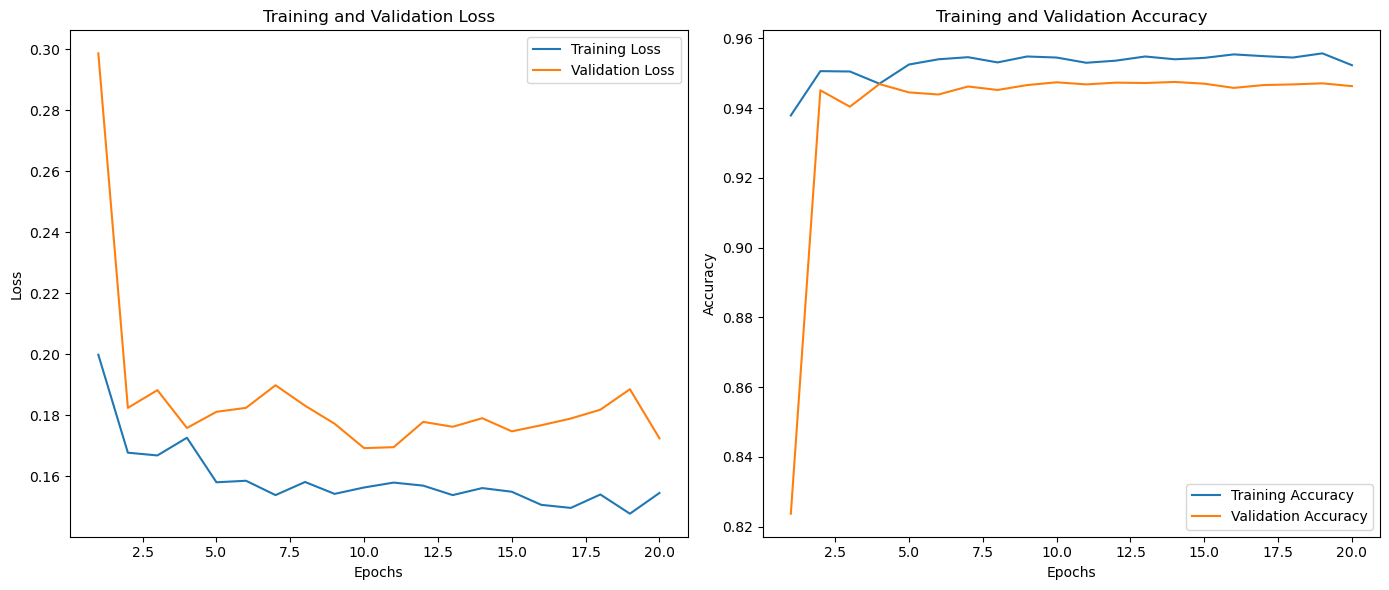

In [27]:
import matplotlib.pyplot as plt

# Data from the model training output
epochs = range(1, 21)
train_loss = [0.1999, 0.1678, 0.1669, 0.1727, 0.1581, 0.1586, 0.1539, 0.1582, 0.1543, 0.1564, 
              0.1580, 0.1570, 0.1539, 0.1562, 0.1550, 0.1507, 0.1497, 0.1541, 0.1478, 0.1546]
val_loss = [0.2987, 0.1825, 0.1883, 0.1759, 0.1812, 0.1825, 0.1899, 0.1832, 0.1773, 0.1693, 
            0.1696, 0.1779, 0.1763, 0.1791, 0.1748, 0.1768, 0.1790, 0.1819, 0.1886, 0.1725]
train_accuracy = [0.9379, 0.9506, 0.9505, 0.9470, 0.9525, 0.9540, 0.9546, 0.9531, 0.9548, 0.9545, 
                 0.9530, 0.9536, 0.9548, 0.9540, 0.9544, 0.9554, 0.9549, 0.9545, 0.9557, 0.9523]
val_accuracy = [0.8237, 0.9451, 0.9404, 0.9469, 0.9445, 0.9439, 0.9462, 0.9452, 0.9466, 0.9474, 
               0.9468, 0.9473, 0.9472, 0.9475, 0.9470, 0.9458, 0.9466, 0.9468, 0.9471, 0.9463]


# Plotting the training and validation loss
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plots
plt.tight_layout()
plt.show()


In [28]:
# %%capture
# model = load_model('UNet_dense_10_epoch.h5')
# predict1(model, images, masks, output_dir, 'dense')

# import h5p
input_dir = './data_new/'
mask_dir = './GEE_Masks/GEE_resized/test_gee/'
output_dir = './GEE_Output/Adversarial/Clean'

# Load data
# images, masks = load_data_test(input_dir, mask_dir)

# model = load_model()



In [29]:
model = tf.keras.models.load_model('./Model/UNet_dense_GEE_20_epoch', compile=False)
model.compile()
predict1(model,mask_dir,input_dir, output_dir, 'dense')

253
NDWI_Mask_1008_resized.tif
1008
./data_new/1008.tif
1/1 [==============================] - 0s 468ms/step
NDWI_Mask_1010_resized.tif
1010
./data_new/1010.tif
1/1 [==============================] - 0s 14ms/step
NDWI_Mask_1012_resized.tif
1012
./data_new/1012.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1020_resized.tif
1020
./data_new/1020.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1025_resized.tif
1025
./data_new/1025.tif
1/1 [==============================] - 0s 21ms/step
NDWI_Mask_1028_resized.tif
1028
./data_new/1028.tif
1/1 [==============================] - 0s 28ms/step
NDWI_Mask_1030_resized.tif
1030
./data_new/1030.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1031_resized.tif
1031
./data_new/1031.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1035_resized.tif
1035
./data_new/1035.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_1037_resized.tif
1037
./data_new/1037.tif
1/1 [==

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_1061_resized.tif
1061
./data_new/1061.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_106_resized.tif
106
./data_new/106.tif
1/1 [==============================] - 0s 14ms/step
NDWI_Mask_1073_resized.tif
1073
./data_new/1073.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_1075_resized.tif
1075
./data_new/1075.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1079_resized.tif
1079
./data_new/1079.tif
1/1 [==============================] - 0s 10ms/step
NDWI_Mask_1086_resized.tif
1086
./data_new/1086.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_1094_resized.tif
1094
./data_new/1094.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_10_resized.tif
10
./data_new/10.tif
1/1 [==============================] - 0s 14ms/step
NDWI_Mask_1103_resized.tif
1103
./data_new/1103.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1114_resized.tif
1114
./data_new/1114.tif
1/1 [==============================] - 0s 3ms/step
NDWI_Mask_1119_resized.tif
1119
./data_new/1119.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1124_resized.tif
1124
./data_new/1124.tif
1/1 [==============================] - 0s 27ms/step
NDWI_Mask_1130_resized.tif
1130
./data_new/1130.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1131_resized.tif
1131
./data_new/1131.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1139_resized.tif
1139
./data_new/1139.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1142_resized.tif
1142
./data_new/1142.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1149_resized.tif
1149
./data_new/1149.tif
1/1 [==============

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_1161_resized.tif
1161
./data_new/1161.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_1164_resized.tif
1164
./data_new/1164.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_1165_resized.tif
1165
./data_new/1165.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1168_resized.tif
1168
./data_new/1168.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1170_resized.tif
1170
./data_new/1170.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1178_resized.tif
1178
./data_new/1178.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_117_resized.tif
117
./data_new/117.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1180_resized.tif
1180
./data_new/1180.tif
1/1 [==============================] - 0s 6ms/step
NDWI_Mask_1181_resized.tif
1181
./data_new/1181.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1187_resized.tif
1187
./data_new/1187.tif
1/1 [===========

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_1239_resized.tif
1239
./data_new/1239.tif
1/1 [==============================] - 0s 29ms/step
NDWI_Mask_1252_resized.tif
1252
./data_new/1252.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_125_resized.tif
125
./data_new/125.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_1262_resized.tif
1262
./data_new/1262.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_129_resized.tif
129
./data_new/129.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_133_resized.tif
133
./data_new/133.tif
1/1 [==============================] - 0s 9ms/step
NDWI_Mask_139_resized.tif
139
./data_new/139.tif
1/1 [==============================] - 0s 22ms/step
NDWI_Mask_143_resized.tif
143
./data_new/143.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_151_resized.tif
151
./data_new/151.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_154_resized.tif
154
./data_new/154.tif
1/1 [=============================

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_37_resized.tif
37
./data_new/37.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_385_resized.tif
385
./data_new/385.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_38_resized.tif
38
./data_new/38.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_394_resized.tif
394
./data_new/394.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_405_resized.tif
405
./data_new/405.tif
1/1 [==============================] - 0s 31ms/step
NDWI_Mask_418_resized.tif
418
./data_new/418.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_41_resized.tif
41
./data_new/41.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_429_resized.tif
429
./data_new/429.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_43_resized.tif
43
./data_new/43.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_440_resized.tif
440
./data_new/440.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_441_resized.tif
441
./data_new/441.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_443_resized.tif
443
./data_new/443.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_447_resized.tif
447
./data_new/447.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_44_resized.tif
44
./data_new/44.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_450_resized.tif
450
./data_new/450.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_455_resized.tif
455
./data_new/455.tif
1/1 [==============================] - 0s 31ms/step
NDWI_Mask_460_resized.tif
460
./data_new/460.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_464_resized.tif
464
./data_new/464.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_466_resized.tif
466
./data_new/466.tif
1/1 [==============================] - 0s 16m

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_584_resized.tif
584
./data_new/584.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_591_resized.tif
591
./data_new/591.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_595_resized.tif
595
./data_new/595.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_596_resized.tif
596
./data_new/596.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_599_resized.tif
599
./data_new/599.tif
1/1 [==============================] - 0s 31ms/step
NDWI_Mask_603_resized.tif
603
./data_new/603.tif
1/1 [==============================] - 0s 6ms/step
NDWI_Mask_604_resized.tif
604
./data_new/604.tif
1/1 [==============================] - 0s 11ms/step
NDWI_Mask_612_resized.tif
612
./data_new/612.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_614_resized.tif
614
./data_new/614.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_616_resized.tif
616
./data_new/616.tif
1/1 [==============================] - 0s 1

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_655_resized.tif
655
./data_new/655.tif
1/1 [==============================] - 0s 21ms/step
NDWI_Mask_657_resized.tif
657
./data_new/657.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_666_resized.tif
666
./data_new/666.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_66_resized.tif
66
./data_new/66.tif
1/1 [==============================] - 0s 26ms/step
NDWI_Mask_671_resized.tif
671
./data_new/671.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_672_resized.tif
672
./data_new/672.tif
1/1 [==============================] - 0s 8ms/step
NDWI_Mask_675_resized.tif
675
./data_new/675.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_679_resized.tif
679
./data_new/679.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_688_resized.tif
688
./data_new/688.tif
1/1 [==============================] - 0s 19ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_693_resized.tif
693
./data_new/693.tif
1/1 [==============================] - 0s 17ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_694_resized.tif
694
./data_new/694.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_695_resized.tif
695
./data_new/695.tif
1/1 [==============================] - 0s 19ms/step
NDWI_Mask_697_resized.tif
697
./data_new/697.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_712_resized.tif
712
./data_new/712.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_71_resized.tif
71
./data_new/71.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_720_resized.tif
720
./data_new/720.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_721_resized.tif
721
./data_new/721.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_72_resized.tif
72
./data_new/72.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_733_resized.tif
733
./data_new/733.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_73_resized.tif
73
./data_new/73.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_740_resized.tif
740
./data_new/740.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_746_resized.tif
746
./data_new/746.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_754_resized.tif
754
./data_new/754.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_763_resized.tif
763
./data_new/763.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_767_resized.tif
767
./data_new/767.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_770_resized.tif
770
./data_new/770.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_771_resized.tif
771
./data_new/771.tif
1/1 [==============================] - 0s 25ms/step
NDWI_Mask_783_resized.tif
783
./data_new/783.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_78_resized.tif
78
./data_new/78.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_790_resized.tif
790
./data_new/790.tif
1/1 [==============================] - 0s 939us/step
NDWI_Mask_793_resized.tif
793
./data_new/793.tif
1/1 [==============================] - 0s 16

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_814_resized.tif
814
./data_new/814.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_837_resized.tif
837
./data_new/837.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_838_resized.tif
838
./data_new/838.tif
1/1 [==============================] - 0s 15ms/step
NDWI_Mask_846_resized.tif
846
./data_new/846.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_847_resized.tif
847
./data_new/847.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_848_resized.tif
848
./data_new/848.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_851_resized.tif
851
./data_new/851.tif
1/1 [==============================] - 0s 24ms/step
NDWI_Mask_860_resized.tif
860
./data_new/860.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_864_resized.tif
864
./data_new/864.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_865_resized.tif
865
./data_new/865.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_875_resized.tif
875
./data_new/875.tif
1/1 [==============================] - 0s 

c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_893_resized.tif
893
./data_new/893.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_8_resized.tif
8
./data_new/8.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_900_resized.tif
900
./data_new/900.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_911_resized.tif
911
./data_new/911.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_914_resized.tif
914
./data_new/914.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_918_resized.tif
918
./data_new/918.tif
1/1 [==============================] - 0s 20ms/step
NDWI_Mask_91_resized.tif
91
./data_new/91.tif
1/1 [==============================] - 0s 17ms/step
NDWI_Mask_925_resized.tif
925
./data_new/925.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_928_resized.tif
928
./data_new/928.tif
1/1 [==============================] - 0s 18ms/step
NDWI_Mask_930_resized.tif
930
./data_new/930.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_931_resized.tif
931
./data_new/931.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_938_resized.tif
938
./data_new/938.tif
1/1 [==============================] - 0s 24ms/step
NDWI_Mask_93_resized.tif
93
./data_new/93.tif
1/1 [==============================] - 0s 7ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_941_resized.tif
941
./data_new/941.tif
1/1 [==============================] - 0s 18ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_948_resized.tif
948
./data_new/948.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_950_resized.tif
950
./data_new/950.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_955_resized.tif
955
./data_new/955.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_957_resized.tif
957
./data_new/957.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1760: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


NDWI_Mask_95_resized.tif
95
./data_new/95.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_960_resized.tif
960
./data_new/960.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_974_resized.tif
974
./data_new/974.tif
1/1 [==============================] - 0s 16ms/step


c:\Users\ADMIN\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


NDWI_Mask_983_resized.tif
983
./data_new/983.tif
1/1 [==============================] - 0s 31ms/step
NDWI_Mask_986_resized.tif
986
./data_new/986.tif
1/1 [==============================] - 0s 16ms/step
NDWI_Mask_9_resized.tif
9
./data_new/9.tif
1/1 [==============================] - 0s 17ms/step
Mean Dice Coefficient: 0.7695950295506301
Mean IoU: 0.7101542882802705
Mean Precision: 0.7583049044881496
Mean Recall: 0.7034399168083143
Mean F1 Score: 0.6997079555046324


(0.7695950295506301,
 0.7101542882802705,
 0.7583049044881496,
 0.7034399168083143,
 0.6997079555046324)

In [ ]:
# model = residual_unet(input_shape)
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# # Train the model
# model.fit(images, masks, validation_split=0.1, epochs=10, batch_size=2)
# model.save('UNet_residual_10_epoch.h5')

In [ ]:
# %%capture
# model = load_model("UNet_residual_10_epoch.h5")
# predict(model, images, masks, output_dir, 'residual')